# Generating heatmap for the chemotaxonomy

### Import modules

In [1]:
from collections import defaultdict
from ast import literal_eval

import pandas as pd
import numpy as np
from tqdm import tqdm

# Import taxonomy
from utils import get_genus_and_family_info_for_plants

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

/Users/danieldomingo/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
sns.set_style("whitegrid")
mpl.rcParams['figure.dpi'] = 360
%matplotlib inline

In [3]:
tqdm.pandas()
pd.set_option('display.max_columns', None)

Load chemicals

In [4]:
plant_chemical_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/plant_chemical_associations.tsv.zip',
    compression='zip',
    sep='\t',
    usecols=[
        'plant_curie',
        'chemical_curie',
    ]
)

In [5]:
plant_chemical_df.head(1)

,plant_curie,chemical_curie
0,ncbitaxon:1000425,pubchem.compound:3527


In [6]:
len(plant_chemical_df.chemical_curie.unique())

71179

### Extract chemical classes

Load ClassyFire classes

In [7]:
classyfire_dict = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/classyfire_smiles.tsv.gz',
    sep='\t',
    compression='gzip',
    usecols=[
        'smiles',
        'class.name'
    ],
    index_col='smiles'
).to_dict()['class.name']

In [8]:
len(classyfire_dict)

64321

Load NPClassifier classes

In [9]:
np_classifier_dict = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/npclassifier_smiles.tsv.gz',
    sep='\t',
    compression='gzip',
    usecols=[
        'pubchem_openeye_can_smiles',
        'class_results'
    ],
    index_col='pubchem_openeye_can_smiles'
).to_dict()['class_results']

In [10]:
len(np_classifier_dict)

638605

Convert the SMILEs to PubChem ids

In [11]:
smiles_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/smiles.tsv.gz',
    sep='\t',
    compression='gzip',
)

In [12]:
pubchem_to_smiles = {}
all_smiles = set()

chemicals_in_plants = set(plant_chemical_df.chemical_curie.unique())

for pubchem_id, smiles in tqdm(smiles_df.values):
        
    if pubchem_id.startswith('pubchem:'):
        pubchem_id = pubchem_id.replace('pubchem:', 'pubchem.compound:')
        
    if pubchem_id not in chemicals_in_plants:
        continue
    
    all_smiles.add(smiles)
    pubchem_to_smiles[pubchem_id] = smiles

smiles_to_pubchem = {
    smiles: pubchem
    for pubchem, smiles in pubchem_to_smiles.items()
}

100%|██████████| 323369/323369 [00:00<00:00, 475332.94it/s]


In [13]:
classyfire_dict = {
    smiles_to_pubchem[smile]: classes
    for smile, classes in classyfire_dict.items()
    if smile in smiles_to_pubchem
}
len(classyfire_dict)

1644

In [14]:
# Multiple classes associated with each chemical
np_classifier_dict = {
    smiles_to_pubchem[smile]: literal_eval(classes)
    for smile, classes in np_classifier_dict.items()
    if smile in smiles_to_pubchem and len(literal_eval(classes)) > 0
}
len(np_classifier_dict)

37859

### Compound class annotation

In [15]:
classyfire_annotated_plants = plant_chemical_df.copy(deep=True)
classyfire_annotated_plants['class'] = classyfire_annotated_plants['chemical_curie'].map(classyfire_dict)

In [16]:
# all plants
classyfire_annotated_plants.shape

(330655, 3)

In [17]:
classyfire_annotated_plants.dropna(subset=['class'], inplace=True)

In [18]:
classyfire_annotated_plants.shape

(11605, 3)

In [19]:
classyfire_annotated_plants['class'].value_counts()

Prenol lipids                               2909
Fatty Acyls                                 2649
Saturated hydrocarbons                      1564
Organooxygen compounds                      1499
Benzene and substituted derivatives          615
                                            ... 
Oxolanes                                       1
Organic phosphoric acids and derivatives       1
Organobromides                                 1
Organic sulfonic acids and derivatives         1
Organic sulfuric acids and derivatives         1
Name: class, Length: 82, dtype: int64

In [20]:
np_classifier_annotated_plants = plant_chemical_df.copy(deep=True)
np_classifier_annotated_plants['class'] = np_classifier_annotated_plants['chemical_curie'].map(np_classifier_dict)
np_classifier_annotated_plants = np_classifier_annotated_plants.explode('class')

In [21]:
# all plants
np_classifier_annotated_plants.shape

(357412, 3)

In [22]:
np_classifier_annotated_plants.dropna(subset=['class'], inplace=True)

In [23]:
np_classifier_annotated_plants.shape

(251717, 3)

In [24]:
np_classifier_annotated_plants['class'].value_counts()

Flavonols                         18854
Flavones                          12019
Cinnamic acids and derivatives     8380
Oleanane triterpenoids             6853
Simple phenolic acids              6469
                                  ...  
Cephamycins                           1
Other Docosanoids                     1
Isoaurones                            1
Griseofulvins                         1
Thia fatty acids                      1
Name: class, Length: 524, dtype: int64

### Create plant-class vectors
e.g., plant A: [class1, class2, class3, ...]

In [25]:
def create_np_classifier_vectors(df: pd.DataFrame):
    all_classes = set(df['class'].unique())
    plants = set(df['plant_curie'].unique())
    
    vector_data = []
    
    for plant_name in tqdm(plants, desc='Generated NP-Classifier vectors'):
        phytochem_df = df[df['plant_curie'] == plant_name]
        
        t = {
            'plant_name': plant_name,
        }
        
        for class_name in all_classes:
            temp = phytochem_df[phytochem_df['class'] == class_name]
            t[class_name] = len(temp['chemical_curie'].unique())
        
        vector_data.append(t)
            
    return pd.DataFrame(vector_data)
    

def create_classyfire_vectors(df: pd.DataFrame):
    all_classes = set(df['class'].unique())
    plants = set(df['plant_curie'].unique())
    
    vector_data = []
    
    for plant_name in tqdm(plants, desc='Generated Classifier vectors'):
        phytochem_df = df[df['plant_curie'] == plant_name]
        
        t = {
            'plant_name': plant_name,
        }
        
        for class_name in all_classes:
            temp = phytochem_df[phytochem_df['class'] == class_name]
            t[class_name] = len(temp['chemical_curie'].unique())
        
        vector_data.append(t)
            
    return pd.DataFrame(vector_data)

In [26]:
plant_to_npclassifier_vectors = create_np_classifier_vectors(np_classifier_annotated_plants)

Generated NP-Classifier vectors: 100%|██████████| 15859/15859 [46:50<00:00,  5.64it/s] 


In [27]:
plant_to_npclassifier_vectors.head(2)

,plant_name,Androstane steroids,Bergamotane sesquiterpenoids,Hydroxy-hydroperoxyeicosatetraenoic acids,Icetexane diterpenoids,Hopane and Moretane triterpenoids,Glucosinolates,Panasinsane sesquiterpenoids,Fatty alcohols,Pacifigorgiane sesquiterpenoids,Aristolane sesquiterpenoids,Fatty nitriles,Guanacastane diterpenoids,Gallotannins,Trachylobane diterpenoids,Simple phenolic acids,Dolabellane diterpenoids,Azaphilones,Fatty acyl CoAs,Iboga type,"Carotenoids (C40, β-ε)",Monomeric stilbenes,Polyprenol derivatives,Ansa peptide alkaloids,Flavonolignans,Naphthoquinones,Drimane sesquiterpenoids,Boromycins,Monocyclic monoterpenoids,Ahp-containing cyclodepsipeptides,Triacylglycerols,Wax monoesters,Hydrocarbons,Dicarboxylic acids,Steroidal alkaloids,m-Terphenyls,Kaurane and Phyllocladane diterpenoids,Aeruginosins,Bicyclohumulane sesquiterpenoids,Anthranillic acid derivatives,Eudesmane sesquiterpenoids,Ansa macrolides,Humulane sesquiterpenoids,Spirostane steroids,Terpenoid tetrahydroisoquinoline alkaloids,Camphane monoterpenoids,Prostaglandins,Cinnamoyl phenols,Oplopane sesquiterpenoids,Proanthocyanins,Valerenane sesquiterpenoids,Flavonostilbenes,Cucurbitane triterpenoids,Longipinane sesquiterpenoids,Nardosinane sesquiterpenoids,Cyathane diterpenoids,Segetane diterpenoids,Cannabinoids,Fungal DPEs,Disaccharides,Cuparane sesquiterpenoids,Patchoulane sesquiterpenoids,Chromones,Protoberberine alkaloids,Carbazole alkaloids,Glycerophosphates,Isoflavones,Furofuranoid lignans,Kavalactones and derivatives,Multiflorane triterpenoids,Polyether ionophores,Mulinane diterpenoids,Cadinane sesquiterpenoids,Acorane sesquiterpenoids,Presilphiperfolane and Probotryane sesquiterpenoids,"Carotenoids (C40, ε-Ψ)",Silphiperfolane sesquiterpenoids,Miscellaneous polyketides,Methyl xanthones,Pregnane steroids,Pyrrolizidine alkaloids,Aminoglycosides,Acridone alkaloids,Acyl phloroglucinols,Serratane triterpenoids,Cardenolides,Quinolizidine alkaloids,Glycerophosphoglycerophosphoglycerols,Pyridine alkaloids,"Carotenoids (C40, β-κ)",Phenanthrenes,Aplysiatoxins,Perforane sesquiterpenoids,Linear diarylheptanoids,Secoiridoid monoterpenoids,Isoaurones,Parguerane diterpenoids,Tetrahydroisoquinoline alkaloids,Saxitoxins,Humbertiane sesquiterpenoids,Ceramides,Sphingoid bases,Cleistanthane diterpenoids,3-acyl tetramic acids,Prenylbisabolane diterpenoids,Hasubanan alkaloids,Monoacylglycerols,"Lanostane, Tirucallane and Euphane triterpenoids",Oxo fatty acids,Isoflavanones,Simple oxindole alkaloids,Bourbonane sesquiterpenoids,Coloratane sesquiterpenoids,Megastigmanes,Limonoids,Abeolupane triterpenoids,Biaryl type diarylheptanoids,Jatrophane diterpenoids,Mycosporine and Mycosporine-like amino acids,Gibberellins,Carboline alkaloids,Betalain alkaloids,Cycloapotirucallane triterpenoids,Vitamin D2 and derivatives,Daucane sesquiterpenoids,Dolastane diterpenoids,Indole-Diterpenoid alkaloids (Penitrems),Longibornane sesquiterpenoids,Triketide meroterpenoids,Clovane sesquiterpenoids,Cyclic peptides,Oxasqualenoids,3-Spirotetramic acids,Secochamigrane sesquiterpenoids,Pterocarpan,Stemona alkaloids,Lupane triterpenoids,Abeoabietane diterpenoids,Shikimic acids and derivatives,Naphthalenones,Norkaurane diterpenoids,Sphenolobane diterpenoids,Verrucosane diterpenoids,Protopine alkaloids,RiPPs-Cyanobactins,Sacculatane diterpenoids,Isoprostanes,Cycloeudesmane sesquiterpenoids,Elemane sesquiterpenoids,Norlabdane diterpenoids,Simple aromatic polyketides,Furocoumarins,Tremulane sesquiterpenoids,N-acyl amines,Cholestane steroids,Grayanotoxane diterpenoids,Myrsinane diterpenoids,Acyclic monoterpenoids,Dammarane and Protostane triterpenoids,Marasmane sesquiterpenoids,Spriromeroterpenoids,Homoerythrina alkaloids,Rhamnolipids,Anabaenopeptins,Arylnaphthalene and aryltetralin lignans,Menthane monoterpenoids,Cytochalasan alkaloids,Lactones,Dibenzylbutane lignans,Dialkylresorcinols,Cyclogermacrane sesquiterpenoids,Wax diesters,Linear tetronates,Copacamphane sesquiterpenoids,Phenoxazine alkaloids,Oligomeric phlor

In [28]:
plant_to_classyfire_vectors = create_classyfire_vectors(classyfire_annotated_plants)

Generated Classifier vectors: 100%|██████████| 2978/2978 [01:41<00:00, 29.37it/s]


In [29]:
plant_to_classyfire_vectors.head(2)

,plant_name,Piperidines,Organobromides,Organic sulfuric acids and derivatives,Unsaturated hydrocarbons,Phenalenes,Thiosulfinic acid esters,Diazanaphthalenes,Organic phosphoric acids and derivatives,Pyrrolidines,Diazines,Dioxanes,Tetrathianes,Polycyclic hydrocarbons,Dithianes,Lactones,Benzopyrazoles,Azolidines,Imidazopyrimidines,Benzene and substituted derivatives,Tetralins,Pyrans,Hydroxy acids and derivatives,Azoles,Cinnamaldehydes,Saturated hydrocarbons,Quinolines and derivatives,Organic phosphines and derivatives,Dithiins,Tetrahydrofurans,Isothiocyanates,Organic disulfides,Allyl sulfur compounds,Pyrrolizidines,Sulfonyls,Pyrroles,Oxanes,Benzopyrans,Tetrahydroisoquinolines,Tropones,Benzothiazoles,Sulfinyl compounds,Epoxides,Pyrrolines,Oxazinanes,Trithianes,Keto acids and derivatives,Thiols,Phenols,Benzimidazoles,Benzoxazines,Organic trisulfides,Thioacetals,Dihydrofurans,Dithiolanes,Heteroaromatic compounds,Organooxygen compounds,Coumarins and derivatives,Tropane alkaloids,Organoiodides,Azepanes,Sulfoxides,Prenol lipids,Isocoumarins and derivatives,Carboxylic acids and derivatives,Phenol ethers,Organic dithiophosphoric acids and derivatives,Organonitrogen compounds,Macrolactams,Oxolanes,Sulfenyl compounds,Thiophenes,Pyridines and derivatives,Fatty Acyls,Glycerolipids,Thioethers,Naphthalenes,Cinnamic acids and derivatives,Organic sulfonic acids and derivatives,Furans,Organometalloid compounds,Indoles and derivatives,"3,4-dihydrocoumarins"
0,ncbitaxon:363212,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ncbitaxon:124774,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Collapsing plant species to plant families

In [30]:
genus_to_species, family_to_species = get_genus_and_family_info_for_plants(
    set(plant_chemical_df.plant_curie.unique())
)

order genus: 100%|██████████| 16884/16884 [00:00<00:00, 28240.82it/s]


# TODO: Plot the number of chemicals per family/genus

In [42]:
def plot_chemical_distribution(taxon_to_species):
    """Plot chemical distribution."""
    
    rows = []
    
    for taxon_name, species in tqdm(taxon_to_species.items()):
        unique_chemicals = plant_chemical_df[
            plant_chemical_df['plant_curie'].isin(species)
        ].chemical_curie.unique()
        
        rows.append({
            'taxon_group': taxon_name,
            'chemical_count': len(unique_chemicals),
        })
        
    df = pd.DataFrame(rows)
    df.set_index('taxon_group', inplace=True)
    
    g = sns.displot(
        data=df,
        x='chemical_count',
        stat="density",
        kde=True,
        common_norm=False,
        height=4,
        aspect=1.5,
        bins=1000,
        alpha=0.7,
    )

#     g.set(xlim=(-1, 10000))

    plt.show()

100%|██████████| 4711/4711 [00:41<00:00, 114.69it/s]


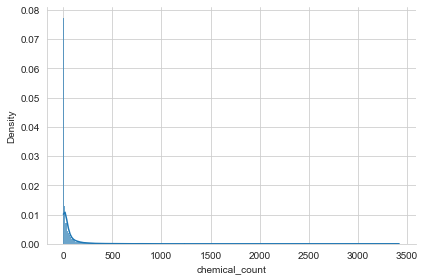

In [43]:
plot_chemical_distribution(genus_to_species)

100%|██████████| 504/504 [00:05<00:00, 90.29it/s] 


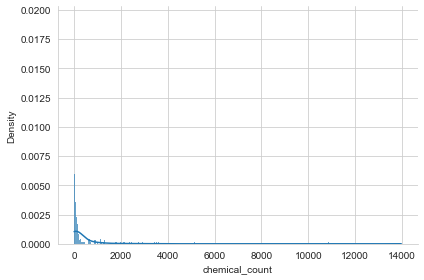

In [44]:
plot_chemical_distribution(family_to_species)

# TODO: Fixme and export without medicinal and non medicinal but all together

In [54]:
def collapse_to_family(df: pd.DataFrame, taxon_group):
    
    data = []
    skipped_empty = 0
    skipped_low = 0
    
    for family_curie, species in tqdm(taxon_group.items()):
        tmp_df = df[df['plant_name'].isin(species)]
        
        if tmp_df.empty:
            skipped_empty +=1
            continue
            
        tmp_df = tmp_df.drop(columns=['plant_name'])
        
        # Remove family/genus with chemical class less than 10
        if tmp_df.sum().sum() < 10:
            skipped_low +=1
            continue
        
        row_dict = tmp_df.sum().to_dict()
        row_dict['taxon'] = family_curie
        
        data.append(row_dict)

    print('Empty skipped empty:', skipped_empty)
    print('Empty skipped less than 10 chemicals:', skipped_low)
    
    df = pd.DataFrame(data)
    df.set_index('taxon', inplace=True)
    df.fillna(0, inplace=True)

    return df

        

In [55]:
classyfire_family_df = collapse_to_family(plant_to_classyfire_vectors, family_to_species)
classyfire_genus_df = collapse_to_family(plant_to_classyfire_vectors, genus_to_species)

classyfire_family_df.head(2)

100%|██████████| 504/504 [00:00<00:00, 663.44it/s]


Empty skipped empty: 235
Empty skipped less than 10 chemicals: 146


100%|██████████| 4711/4711 [00:05<00:00, 938.94it/s] 

Empty skipped empty: 3249
Empty skipped less than 10 chemicals: 1208


,Piperidines,Organobromides,Organic sulfuric acids and derivatives,Unsaturated hydrocarbons,Phenalenes,Thiosulfinic acid esters,Diazanaphthalenes,Organic phosphoric acids and derivatives,Pyrrolidines,Diazines,Dioxanes,Tetrathianes,Polycyclic hydrocarbons,Dithianes,Lactones,Benzopyrazoles,Azolidines,Imidazopyrimidines,Benzene and substituted derivatives,Tetralins,Pyrans,Hydroxy acids and derivatives,Azoles,Cinnamaldehydes,Saturated hydrocarbons,Quinolines and derivatives,Organic phosphines and derivatives,Dithiins,Tetrahydrofurans,Isothiocyanates,Organic disulfides,Allyl sulfur compounds,Pyrrolizidines,Sulfonyls,Pyrroles,Oxanes,Benzopyrans,Tetrahydroisoquinolines,Tropones,Benzothiazoles,Sulfinyl compounds,Epoxides,Pyrrolines,Oxazinanes,Trithianes,Keto acids and derivatives,Thiols,Phenols,Benzimidazoles,Benzoxazines,Organic trisulfides,Thioacetals,Dihydrofurans,Dithiolanes,Heteroaromatic compounds,Organooxygen compounds,Coumarins and derivatives,Tropane alkaloids,Organoiodides,Azepanes,Sulfoxides,Prenol lipids,Isocoumarins and derivatives,Carboxylic acids and derivatives,Phenol ethers,Organic dithiophosphoric acids and derivatives,Organonitrogen compounds,Macrolactams,Oxolanes,Sulfenyl compounds,Thiophenes,Pyridines and derivatives,Fatty Acyls,Glycerolipids,Thioethers,Naphthalenes,Cinnamic acids and derivatives,Organic sulfonic acids and derivatives,Furans,Organometalloid compounds,Indoles and derivatives,"3,4-dihydrocoumarins"
taxon,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ncbitaxon:16714,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,4,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,2,0,0,0,0,0,0
ncbitaxon:4118,0,0,0,0,0,0,0,0,6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,6,0,0,0,0,3,0,0,0,0,0,11,1,0,0,0,0,0,0,0,0


In [61]:
np_classyfire_family_df = collapse_to_family(plant_to_npclassifier_vectors, family_to_species)
np_classyfire_genus_df = collapse_to_family(plant_to_npclassifier_vectors, genus_to_species)

100%|██████████| 504/504 [00:02<00:00, 210.23it/s]


Empty skipped empty: 27
Empty skipped less than 10 chemicals: 112


100%|██████████| 4711/4711 [00:14<00:00, 332.17it/s]


Empty skipped empty: 416
Empty skipped less than 10 chemicals: 1775


In [57]:
classyfire_family_df.to_csv(
    's3://enveda-datascience/daniel_domingo/classyfire_family_vector.parquet', index=False
)
classyfire_genus_df.to_csv(
    's3://enveda-datascience/daniel_domingo/classyfire_genus_vector.parquet', index=False
)

In [62]:
np_classyfire_family_df.to_csv(
    's3://enveda-datascience/daniel_domingo/np_classifier_family_vector.parquet', index=False
)
np_classyfire_genus_df.to_csv(
    's3://enveda-datascience/daniel_domingo/np_classifier_genus_vector.parquet', index=False
)

### Export dataframes as a relative percentage

In [66]:
def convert_to_percent(df: pd.DataFrame):
    """Convert counts to percentages for each row."""
    res = df.div(df.sum(axis=1), axis=0)
    
    a = res.sum(axis=1) 
    assert np.isclose(a.values, [1]*a.shape[0]).all(), 'Not all rows sum to 1'
    return res

In [73]:
classyfire_genus_df = convert_to_percent(classyfire_genus_df)
np_classyfire_genus_df = convert_to_percent(np_classyfire_genus_df)

In [67]:
classyfire_family_df = convert_to_percent(classyfire_family_df)
classyfire_family_df.head(2)

,Piperidines,Organobromides,Organic sulfuric acids and derivatives,Unsaturated hydrocarbons,Phenalenes,Thiosulfinic acid esters,Diazanaphthalenes,Organic phosphoric acids and derivatives,Pyrrolidines,Diazines,Dioxanes,Tetrathianes,Polycyclic hydrocarbons,Dithianes,Lactones,Benzopyrazoles,Azolidines,Imidazopyrimidines,Benzene and substituted derivatives,Tetralins,Pyrans,Hydroxy acids and derivatives,Azoles,Cinnamaldehydes,Saturated hydrocarbons,Quinolines and derivatives,Organic phosphines and derivatives,Dithiins,Tetrahydrofurans,Isothiocyanates,Organic disulfides,Allyl sulfur compounds,Pyrrolizidines,Sulfonyls,Pyrroles,Oxanes,Benzopyrans,Tetrahydroisoquinolines,Tropones,Benzothiazoles,Sulfinyl compounds,Epoxides,Pyrrolines,Oxazinanes,Trithianes,Keto acids and derivatives,Thiols,Phenols,Benzimidazoles,Benzoxazines,Organic trisulfides,Thioacetals,Dihydrofurans,Dithiolanes,Heteroaromatic compounds,Organooxygen compounds,Coumarins and derivatives,Tropane alkaloids,Organoiodides,Azepanes,Sulfoxides,Prenol lipids,Isocoumarins and derivatives,Carboxylic acids and derivatives,Phenol ethers,Organic dithiophosphoric acids and derivatives,Organonitrogen compounds,Macrolactams,Oxolanes,Sulfenyl compounds,Thiophenes,Pyridines and derivatives,Fatty Acyls,Glycerolipids,Thioethers,Naphthalenes,Cinnamic acids and derivatives,Organic sulfonic acids and derivatives,Furans,Organometalloid compounds,Indoles and derivatives,"3,4-dihydrocoumarins"
taxon,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ncbitaxon:16714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.052632,0.0,0.0,0.0,0.210526,0.0,0.0,0.0,0.0,0.0,0.157895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.210526,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.263158,0.000000,0.0,0.105263,0.0,0.0,0.0,0.0,0.0,0.0
ncbitaxon:4118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.171429,0.0,0.0,0.0,0.0,0.0,0.028571,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.057143,0.0,0.0,0.0,0.0,0.0,0.171429,0.0,0.0,0.0,0.0,0.085714,0.0,0.0,0.0,0.0,0.0,0.314286,0.028571,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
np_classyfire_family_df = convert_to_percent(np_classyfire_family_df)
np_classyfire_family_df.head(2)

,Androstane steroids,Bergamotane sesquiterpenoids,Hydroxy-hydroperoxyeicosatetraenoic acids,Icetexane diterpenoids,Hopane and Moretane triterpenoids,Glucosinolates,Panasinsane sesquiterpenoids,Fatty alcohols,Pacifigorgiane sesquiterpenoids,Aristolane sesquiterpenoids,Fatty nitriles,Guanacastane diterpenoids,Gallotannins,Trachylobane diterpenoids,Simple phenolic acids,Dolabellane diterpenoids,Azaphilones,Fatty acyl CoAs,Iboga type,"Carotenoids (C40, β-ε)",Monomeric stilbenes,Polyprenol derivatives,Ansa peptide alkaloids,Flavonolignans,Naphthoquinones,Drimane sesquiterpenoids,Boromycins,Monocyclic monoterpenoids,Ahp-containing cyclodepsipeptides,Triacylglycerols,Wax monoesters,Hydrocarbons,Dicarboxylic acids,Steroidal alkaloids,m-Terphenyls,Kaurane and Phyllocladane diterpenoids,Aeruginosins,Bicyclohumulane sesquiterpenoids,Anthranillic acid derivatives,Eudesmane sesquiterpenoids,Ansa macrolides,Humulane sesquiterpenoids,Spirostane steroids,Terpenoid tetrahydroisoquinoline alkaloids,Camphane monoterpenoids,Prostaglandins,Cinnamoyl phenols,Oplopane sesquiterpenoids,Proanthocyanins,Valerenane sesquiterpenoids,Flavonostilbenes,Cucurbitane triterpenoids,Longipinane sesquiterpenoids,Nardosinane sesquiterpenoids,Cyathane diterpenoids,Segetane diterpenoids,Cannabinoids,Fungal DPEs,Disaccharides,Cuparane sesquiterpenoids,Patchoulane sesquiterpenoids,Chromones,Protoberberine alkaloids,Carbazole alkaloids,Glycerophosphates,Isoflavones,Furofuranoid lignans,Kavalactones and derivatives,Multiflorane triterpenoids,Polyether ionophores,Mulinane diterpenoids,Cadinane sesquiterpenoids,Acorane sesquiterpenoids,Presilphiperfolane and Probotryane sesquiterpenoids,"Carotenoids (C40, ε-Ψ)",Silphiperfolane sesquiterpenoids,Miscellaneous polyketides,Methyl xanthones,Pregnane steroids,Pyrrolizidine alkaloids,Aminoglycosides,Acridone alkaloids,Acyl phloroglucinols,Serratane triterpenoids,Cardenolides,Quinolizidine alkaloids,Glycerophosphoglycerophosphoglycerols,Pyridine alkaloids,"Carotenoids (C40, β-κ)",Phenanthrenes,Aplysiatoxins,Perforane sesquiterpenoids,Linear diarylheptanoids,Secoiridoid monoterpenoids,Isoaurones,Parguerane diterpenoids,Tetrahydroisoquinoline alkaloids,Saxitoxins,Humbertiane sesquiterpenoids,Ceramides,Sphingoid bases,Cleistanthane diterpenoids,3-acyl tetramic acids,Prenylbisabolane diterpenoids,Hasubanan alkaloids,Monoacylglycerols,"Lanostane, Tirucallane and Euphane triterpenoids",Oxo fatty acids,Isoflavanones,Simple oxindole alkaloids,Bourbonane sesquiterpenoids,Coloratane sesquiterpenoids,Megastigmanes,Limonoids,Abeolupane triterpenoids,Biaryl type diarylheptanoids,Jatrophane diterpenoids,Mycosporine and Mycosporine-like amino acids,Gibberellins,Carboline alkaloids,Betalain alkaloids,Cycloapotirucallane triterpenoids,Vitamin D2 and derivatives,Daucane sesquiterpenoids,Dolastane diterpenoids,Indole-Diterpenoid alkaloids (Penitrems),Longibornane sesquiterpenoids,Triketide meroterpenoids,Clovane sesquiterpenoids,Cyclic peptides,Oxasqualenoids,3-Spirotetramic acids,Secochamigrane sesquiterpenoids,Pterocarpan,Stemona alkaloids,Lupane triterpenoids,Abeoabietane diterpenoids,Shikimic acids and derivatives,Naphthalenones,Norkaurane diterpenoids,Sphenolobane diterpenoids,Verrucosane diterpenoids,Protopine alkaloids,RiPPs-Cyanobactins,Sacculatane diterpenoids,Isoprostanes,Cycloeudesmane sesquiterpenoids,Elemane sesquiterpenoids,Norlabdane diterpenoids,Simple aromatic polyketides,Furocoumarins,Tremulane sesquiterpenoids,N-acyl amines,Cholestane steroids,Grayanotoxane diterpenoids,Myrsinane diterpenoids,Acyclic monoterpenoids,Dammarane and Protostane triterpenoids,Marasmane sesquiterpenoids,Spriromeroterpenoids,Homoerythrina alkaloids,Rhamnolipids,Anabaenopeptins,Arylnaphthalene and aryltetralin lignans,Menthane monoterpenoids,Cytochalasan alkaloids,Lactones,Dibenzylbutane lignans,Dialkylresorcinols,Cyclogermacrane sesquiterpenoids,Wax diesters,Linear tetronates,Copacamphane sesquiterpenoids,Phenoxazine alkaloids,Oligomeric phloroglucinols 

In [82]:
classyfire_family_df.to_csv('s3://enveda-datascience/daniel_domingo/classyfire_family_percentage_vector.parquet', index=True)
classyfire_genus_df.to_csv('s3://enveda-datascience/daniel_domingo/classyfire_genus_percentage_vector.parquet', index=True)

In [83]:
np_classyfire_family_df.to_csv('s3://enveda-datascience/daniel_domingo/np_classifier_family_percentage_vector.parquet', index=True)
np_classyfire_genus_df.to_csv('s3://enveda-datascience/daniel_domingo/np_classifier_genus_percentage_vector.parquet', index=True)